# Logistic Regression Classifier Using Temporal Decoding
* analyzing eeg signals over time with temporal decoding. 

## Try classification with one run of one subject 
* It has been discovered that adding more data in the form of different runs of a subject as well as including data from different subjects into one classifier, will diminish classification results.
* Below I will classify one run of one subject to show that 

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time

#need this to create pipeline for classification
from sklearn.pipeline import make_pipeline
#for scaling data into n_sample * n_feature array
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#classifer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                         cross_val_multiscore, LinearModel, get_coef, Vectorizer)

import os
import os.path as op
from os import listdir
from os.path import isfile, join
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

#local path
path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data'
allruns_path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data\ica_140_500_0.1'
# plt.close('all')

### Temporal Decoding

In [3]:
epochs = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run1-epo.fif'),
                          preload=True);

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [4]:
# Since roc_auc can only be computed for binary classifcation problems, 
# data needs to be filtered for two events.

epochs = epochs[(epochs.events[:,-1] == 4) | (epochs.events[:,-1] == 5)]

In [5]:
# get X and y parameters for classificaton
# X - samples in the form n_epochs, n_channels, n_times
X = epochs.get_data() 
# events or targets
y = epochs.events[:,-1]

In [6]:
start = time.time()
clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = 'roc_auc')

scores = cross_val_multiscore(time_decod, X,y, cv = 5, n_jobs = 1)
end = time.time()
print("run time: ", end - start)

('run time: ', 20.919999837875366)


In [7]:
scores = np.mean(scores, axis=0)

## What does the plot below mean?
* Data is inputed into classifier in the form of n_epochs * n_channels. This is done 1400 times. once for each time point. 
* The *Sensor space decoding* graph below shows the AUC score at each time point. 

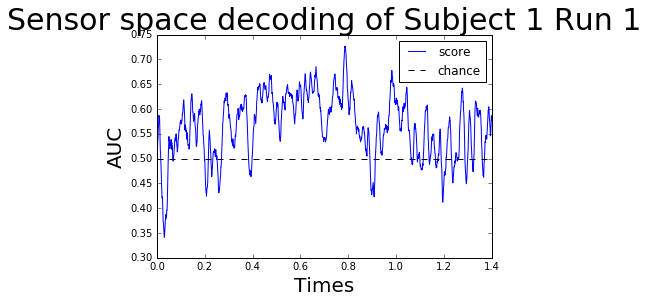

In [8]:
# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times', fontsize = 20)
ax.set_ylabel('AUC', fontsize = 20)  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding of Subject 1 Run 1', fontsize = 30)
plt.show()

In [9]:
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y);

## 

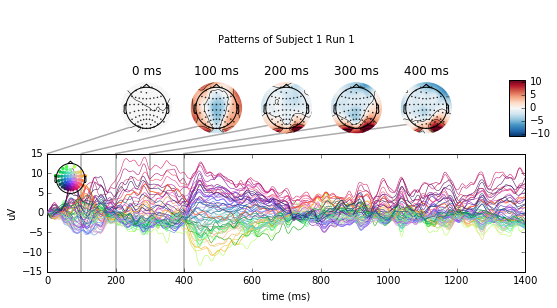

In [10]:
coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0., .500, .100), title='Patterns of Subject 1 Run 1');

## Try with another run of same subject

In [11]:
epochs_run2 = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run2-epo.fif'),
                          preload=True);

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
285 matching events found
Created an SSP operator (subspace dimension = 1)
285 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [12]:
epochs_run2 = epochs_run2[(epochs_run2.events[:,-1] == 4) | (epochs_run2.events[:,-1] == 5)]


In [13]:
# get X and y parameters for classificaton
# X - samples in the form n_epochs, n_channels, n_times
X = epochs_run2.get_data() 
# events or targets
y = epochs_run2.events[:,-1]

In [14]:
start = time.time()
clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = 'roc_auc')

scores_run2 = cross_val_multiscore(time_decod, X,y, cv = 5, n_jobs = 1)
end = time.time()
print("run time: ", end - start)

('run time: ', 20.953999996185303)


In [15]:
scores_run2 = np.mean(scores_run2, axis=0)

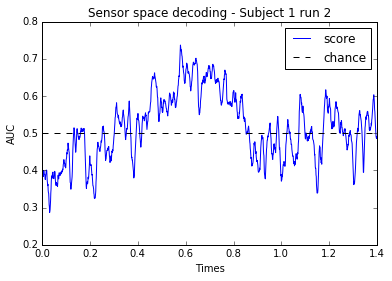

In [16]:
# Plot
fig, ax = plt.subplots()
ax.plot(epochs_run2.times, scores_run2, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding - Subject 1 run 2')
plt.show()

In [17]:
start = time.time()
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

end = time.time()
print "time :", end - start

time : 5.03600001335


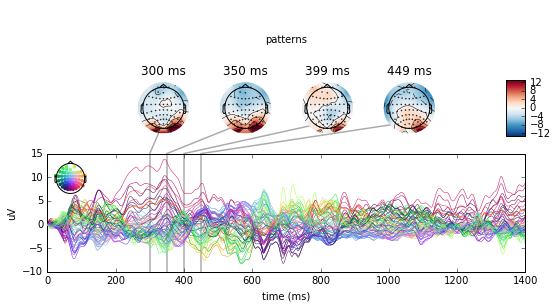

In [18]:
coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0.300, .500, .050), title='patterns');

# Results from run 1 and run 2
* At times .4 to .9, it looks like both lines follow a similar trend with some differences throughout.

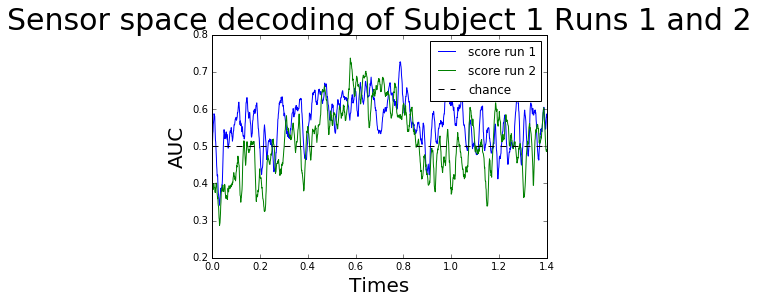

In [19]:
#overlay both plots
# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score run 1')
ax.plot(epochs_run2.times, scores_run2, label = 'score run 2' )
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times', fontsize = 20)
ax.set_ylabel('AUC', fontsize = 20)  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding of Subject 1 Runs 1 and 2', fontsize = 30)
plt.show()

## Results of run 3 and 4

In [20]:
epochs_run3 = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run3-epo.fif'),
                          preload=True);
epochs_run4 = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run4-epo.fif'),
                          preload=True);

epochs_run3 = epochs_run3[(epochs_run3.events[:,-1] == 4) | (epochs_run3.events[:,-1] == 5)]
epochs_run4 = epochs_run4[(epochs_run4.events[:,-1] == 4) | (epochs_run4.events[:,-1] == 5)]

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
287 matching events found
Created an SSP operator (subspace dimension = 1)
287 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
293 matching events found
Created an SSP operator (subspace dimension = 1)
293 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


('run time: ', 21.69099998474121)


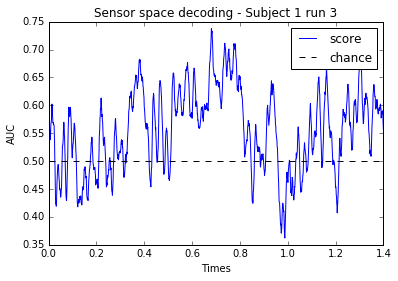

In [21]:
# get X and y parameters for classificaton
# X - samples in the form n_epochs, n_channels, n_times
X = epochs_run3.get_data() 
# events or targets
y = epochs_run3.events[:,-1]

start = time.time()
clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = 'roc_auc')

scores_run3 = cross_val_multiscore(time_decod, X,y, cv = 5, n_jobs = 1)
end = time.time()
print("run time: ", end - start)

scores_run3 = np.mean(scores_run3, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_run3, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding - Subject 1 run 3')
plt.show()

('run time: ', 20.875999927520752)


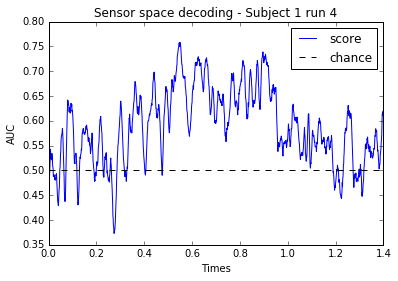

In [22]:
# get X and y parameters for classificaton
# X - samples in the form n_epochs, n_channels, n_times
X = epochs_run4.get_data() 
# events or targets
y = epochs_run4.events[:,-1]

start = time.time()
clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = 'roc_auc')

scores_run4 = cross_val_multiscore(time_decod, X,y, cv = 5, n_jobs = 1)
end = time.time()
print("run time: ", end - start)

scores_run4 = np.mean(scores_run4, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_run4, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding - Subject 1 run 4')
plt.show()

## Summary of results
* In results of all four runs, none have an AUC score of above .76
* What is causing this?
* varaibles to change:
    * What would happen if the StandardScaler was changed to another scaler?
    * How would another classifer perform?
    * Try a different metric for scoring.

## Another method of classification.
* The previous method looked at the accuracy at each point in time. Although this can tell us at what point a subject likely recognizes the image, it is not the best way to solve a classification problem
* We need to approach it in a way that takes features and samples. 
    * What are the features and samples?
      

In [230]:
epochs = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run1-epo.fif'),
                          preload=True);

epochs = epochs[(epochs.events[:,-1] == 4) | (epochs.events[:,-1] == 5)]

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [231]:
# MNE pythons vectorizer converts 3D data into 2D n_samples * n_features
vectorizer = Vectorizer()
scaler = StandardScaler()
vect_epochs = vectorizer.fit_transform(epochs)
scaled_epochs = scaler.fit_transform(vect_epochs) 

In [232]:
print("epochs shape:",epochs.get_data().shape)
print("vectorized and Scaled epochs shape: ", scaled_epochs.shape)

('epochs shape:', (141L, 61L, 1401L))
('vectorized and Scaled epochs shape: ', (141L, 85461L))


In [233]:
vect_epochs.shape

(141L, 85461L)

In [234]:
clf = LogisticRegression()

In [235]:
X = scaled_epochs
y = epochs.events[:,-1]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, 
                                                   random_state = 42)

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [236]:
clf.score(X_test, y_test)

0.69767441860465118

## Use information from AUC graphs to reduce time scale
* Given the results of the previous graphs, the peaks of accuracy are between 400 and 800 milliseconds. 
* Extracting the data just from this range for each epoch may improve performance of the logistic regression classifier.

In [240]:
sliced_epochs = np.array([epoch[:,400:1000] for epoch in epochs.get_data()])
print("shape of sliced epochs between 400:1000 ms", sliced_epochs.shape)

('shape of sliced epochs between 400:1000 ms', (141L, 61L, 600L))


In [241]:
#redo the classification done above

vect_sliced_epochs = vectorizer.fit_transform(sliced_epochs)
scaled_sliced_epochs = scaler.fit_transform(vect_sliced_epochs)

In [242]:
print("sliced epochs shape:",epochs.get_data().shape)
print("vectorized and scaled sliced epochs shape: ", scaled_sliced_epochs.shape)

('sliced epochs shape:', (141L, 61L, 1401L))
('vectorized and scaled sliced epochs shape: ', (141L, 36600L))


In [243]:
X = scaled_sliced_epochs
# y hasn't changed, but just gonna leave this here in case it does change later
y = epochs.events[:,-1]

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, 
                                                   random_state = 42)

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [244]:
clf.score(X_test, y_test)

0.7441860465116279

## Results are misleading
* Although the score increased when reducing the time scale for run 1 of subject 1, the same cannot be said for other runs of the same subject.
* Since each run of a subject is different, results will vary.

## The functions below will help automate the process of testing many files for their score.

In [11]:
#Create function to run over multiple files, store results in an array and plot/display them.

def classify_test(X,y):
    """
    Description: create classication pipeline, cross validation, fit and return score.
    """
    clf = make_pipeline(Vectorizer(),
                        StandardScaler(),
                        LogisticRegression())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    
    clf.fit(X_train, y_train)
    
    score = clf.score(X_test, y_test)
    
    return score

In [12]:
def get_samples_targets(epochs):
    """
    Description: Read an epochs object and return X and y values for samples and targets respectively.
    """
    X = epochs.get_data();
    y = epochs.events[:,-1]
    return X, y

In [13]:
def filter_events(epochs, filter_for):
    """
    Description: Fitler for n_events in the epoch object.
    
    epochs: mne epoch object.
    
    filter_for: a list of events to filter for. ex: [4,5,10]

    """
    
    if len(filter_for) >= len(epochs.event_id):
        return epochs
    
    else:
        temp_epochs = []
        for i in range(len(filter_for)):
            temp_epochs.append(epochs[epochs.events[:,-1] == filter_for[i]])
        
        return mne.concatenate_epochs(temp_epochs)

In [26]:
epochs = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run1-epo.fif'),
                          preload=True);

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [27]:
print(epochs.event_id)

{u'new': 4, u'after': 20, u'scramble': 5, u'before': 10}


In [28]:
epochs = filter_events(epochs,[4,5])

211 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


In [29]:
X, y = get_samples_targets(epochs)

In [30]:
classify_test(X,y)

0.4375

In [61]:
#change this path to your machines correct directory, I will find a workaround later.
all_files_path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data'
drive_path = 'E:\eeg_data'
subject_runs = [f for f in listdir(path) if isfile(join(path, f))]

subject_runs.remove('Ex10_Suj26_Run2-epo.fif')
print(len(subject_runs))

108


In [62]:
scores = []
for f in subject_runs:
    epochs = mne.read_epochs(op.join(path, f),
                          preload=True);
    epochs = filter_events(epochs, [4,5])
    X,y = get_samples_targets(epochs)
    
    scores.append([f, classify_test(X,y)])

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj10_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
149 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj10_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
286 matching events found
Created an SSP operator (subspace dimension = 1)
286 matching events found
Created an SSP operator 

    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
301 matching events found
Created an SSP operator (subspace dimension = 1)
301 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
151 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj14_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
281 matching events found
Created an SSP operator (subspace dimension = 1)
281 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
138 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive

Created an SSP operator (subspace dimension = 1)
259 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
128 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj17_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
287 matching events found
Created an SSP operator (subspace dimension = 1)
287 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
142 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj17_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) ac

143 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj20_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
302 matching events found
Created an SSP operator (subspace dimension = 1)
302 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
151 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj20_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
303 matching events found
Cre

Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
304 matching events found
Created an SSP operator (subspace dimension = 1)
304 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
152 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj24_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
183 matching events found
Created an SSP operator (subspace dimension = 1)
183 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
69 matching events foun

ValueError: zero-size array to reduction operation maximum which has no identity

In [66]:
scores = np.array(scores)
scores

array([['Ex10_Suj10_Run1-epo.fif', '0.666666666667'],
       ['Ex10_Suj10_Run2-epo.fif', '0.809523809524'],
       ['Ex10_Suj10_Run3-epo.fif', '0.595238095238'],
       ['Ex10_Suj10_Run4-epo.fif', '0.711111111111'],
       ['Ex10_Suj11_Run1-epo.fif', '0.526315789474'],
       ['Ex10_Suj11_Run2-epo.fif', '0.722222222222'],
       ['Ex10_Suj11_Run4-epo.fif', '0.346153846154'],
       ['Ex10_Suj12_Run1-epo.fif', '0.583333333333'],
       ['Ex10_Suj12_Run2-epo.fif', '0.355555555556'],
       ['Ex10_Suj12_Run3-epo.fif', '0.595238095238'],
       ['Ex10_Suj12_Run4-epo.fif', '0.487804878049'],
       ['Ex10_Suj13_Run1-epo.fif', '0.608695652174'],
       ['Ex10_Suj13_Run2-epo.fif', '0.644444444444'],
       ['Ex10_Suj13_Run3-epo.fif', '0.555555555556'],
       ['Ex10_Suj13_Run4-epo.fif', '0.45652173913'],
       ['Ex10_Suj14_Run1-epo.fif', '0.571428571429'],
       ['Ex10_Suj14_Run2-epo.fif', '0.555555555556'],
       ['Ex10_Suj14_Run3-epo.fif', '0.619047619048'],
       ['Ex10_Suj14_Run4-epo.

In [75]:
values = [float(x) for x in scores[:,-1]]

(array([  3.,   4.,   4.,  10.,   9.,  16.,  14.,   5.,   2.,   1.]),
 array([ 0.34615385,  0.41153846,  0.47692308,  0.54230769,  0.60769231,
         0.67307692,  0.73846154,  0.80384615,  0.86923077,  0.93461538,  1.        ]),
 <a list of 10 Patch objects>)

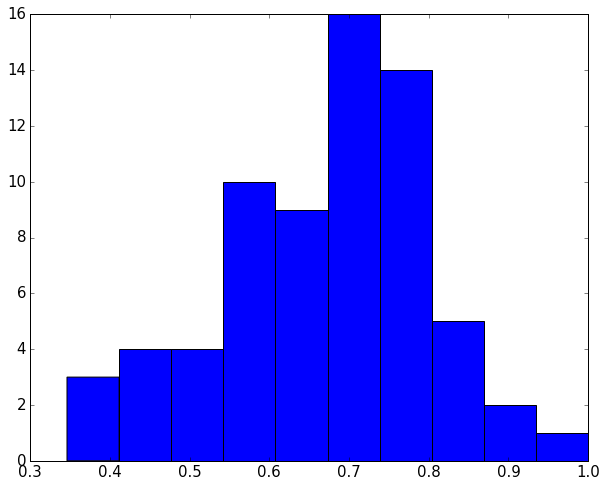

In [86]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(values, bins = 10)

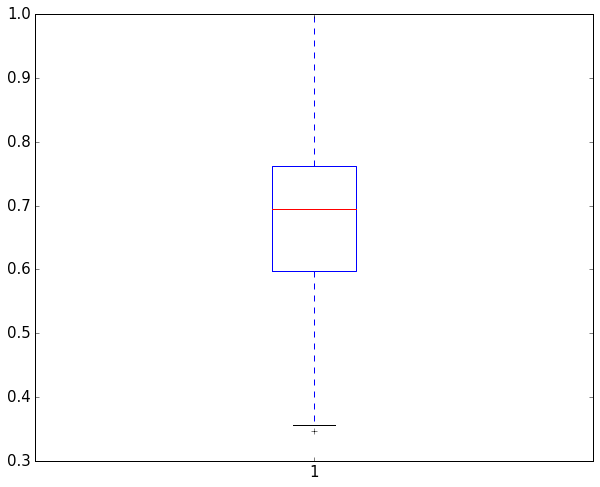

In [32]:
fig, ax = plt.subplots(figsize = (10,8))
ax.boxplot(values_test);

In [17]:
drive_path = 'E:\eeg_data'
subject_runs_test = [f for f in listdir(drive_path) if isfile(join(drive_path, f))]

subject_runs_test.remove('Ex10_Suj26_Run2-epo.fif')
subject_runs_test.remove('Ex10_Suj26_Run4-epo.fif')
# subject_runs_test = subject_runs_test[:1]

In [18]:
scores = []
start = time.time()
for f in subject_runs_test:
    start_loop = time.time()
    epochs = mne.read_epochs(op.join(drive_path, f),
                          preload=True);
    epochs = filter_events(epochs, [4,5])
    X,y = get_samples_targets(epochs)
    
    scores.append([f, classify_test(X,y)])
    end_loop = time.time()
    print("loop runtime: ", end_loop - start_loop)
end = time.time()
print("runtime: ", end - start)

Reading E:\eeg_data\Ex10_Suj10_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
149 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 5.2850000858306885)
Reading E:\eeg_data\Ex10_Suj10_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
286 matching events found
Created an SSP operator (subspace dimension = 1)
286 matching events found
Created an SSP operator (subspace dimension

Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
301 matching events found
Created an SSP operator (subspace dimension = 1)
301 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
151 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.924999952316284)
Reading E:\eeg_data\Ex10_Suj14_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
281 matching events found
Created an SSP operator (subspace dimension = 1)
281 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
138 matching e

    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
259 matching events found
Created an SSP operator (subspace dimension = 1)
259 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
128 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 6.796000003814697)
Reading E:\eeg_data\Ex10_Suj17_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
287 matching events found
Created an SSP operator (subspace dimension = 1)
287 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
142 matching events found
Create

        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
293 matching events found
Created an SSP operator (subspace dimension = 1)
293 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
143 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 7.814000129699707)
Reading E:\eeg_data\Ex10_Suj20_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
302 matching events found
Created an SSP operator (subspace dimension = 1)
302 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
151 matching events found
Created an SSP operator (subspace dimension = 

    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
305 matching events found
Created an SSP operator (subspace dimension = 1)
305 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
153 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 9.353000164031982)
Reading E:\eeg_data\Ex10_Suj23_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
304 matching events found
Created an SSP operator (subspace dimension = 1)
304 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
152 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 9.3

        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
284 matching events found
Created an SSP operator (subspace dimension = 1)
284 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
136 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.503000020980835)
Reading E:\eeg_data\Ex10_Suj27_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
282 matching events found
Created an SSP operator (subspace dimension = 1)
282 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
137 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.986999988555908)
Reading E:\eeg_d

        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
135 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.34499979019165)
Reading E:\eeg_data\Ex10_Suj4_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
275 matching events found
Created an SSP operator (subspace dimension = 1)
275 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
135 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.196000099182129)
Reading E:\eeg_data\Ex10_Suj4_Run3-epo.fif ...
Isotrak not 

291 matching events found
Created an SSP operator (subspace dimension = 1)
291 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
145 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.379999876022339)
Reading E:\eeg_data\Ex10_Suj8_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
299 matching events found
Created an SSP operator (subspace dimension = 1)
299 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
148 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
('loop runtime: ', 8.483999967575073)
Reading E:\eeg_data\Ex10_Suj8_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:

In [25]:
scores=  np.array(scores)
values_test = [float(elem) for elem in scores[:,-1]]

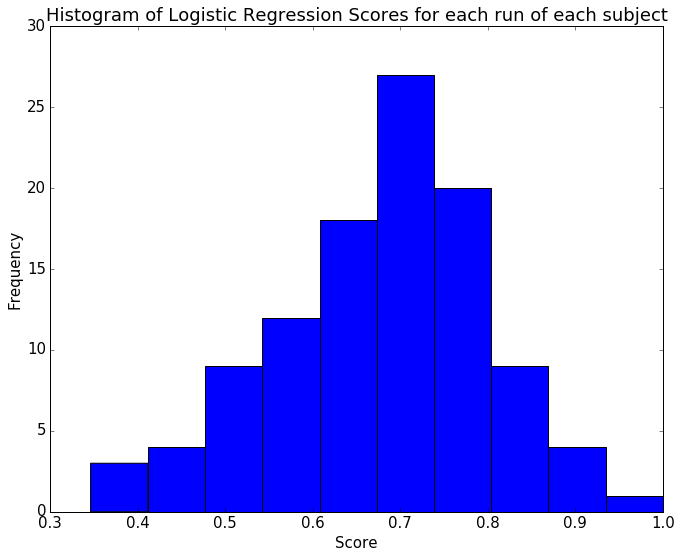

In [38]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(values_test, bins = 10);
ax.set_title('Histogram of Logistic Regression Scores for each run of each subject')
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
fig.tight_layout()

In [37]:
print("mean: ",np.mean(values_test))
print("max: ",np.max(values_test))
print("min: ",np.min(values_test))
print("25th percentile: ",np.percentile(values_test,25 ))
print("50th percentile: ",np.percentile(values_test,50 ))
print("75th percentile: ",np.percentile(values_test,75 ))

('mean: ', 0.67765657227509346)
('max: ', 1.0)
('min: ', 0.34615384615400002)
('25th percentile: ', 0.59761904761899998)
('50th percentile: ', 0.694444444444)
('75th percentile: ', 0.76190476190500001)


## Explore why a file has a perfect score.

In [43]:
scores[scores[:,-1] == '1.0']

array([['Ex10_Suj21_Run1-epo.fif', '1.0']], 
      dtype='|S23')

## Just reading the file shows an abnormality. There are only 14 events for this file.

In [ ]:
epochs = mne.read_epochs(op.join(drive_path, 'Ex10_Suj21_Run1-epo.fif'),
                          preload=True)
# epochs = filter_events(epochs, [4,5])

## Plotting the data confirms the strange behavior of this file.

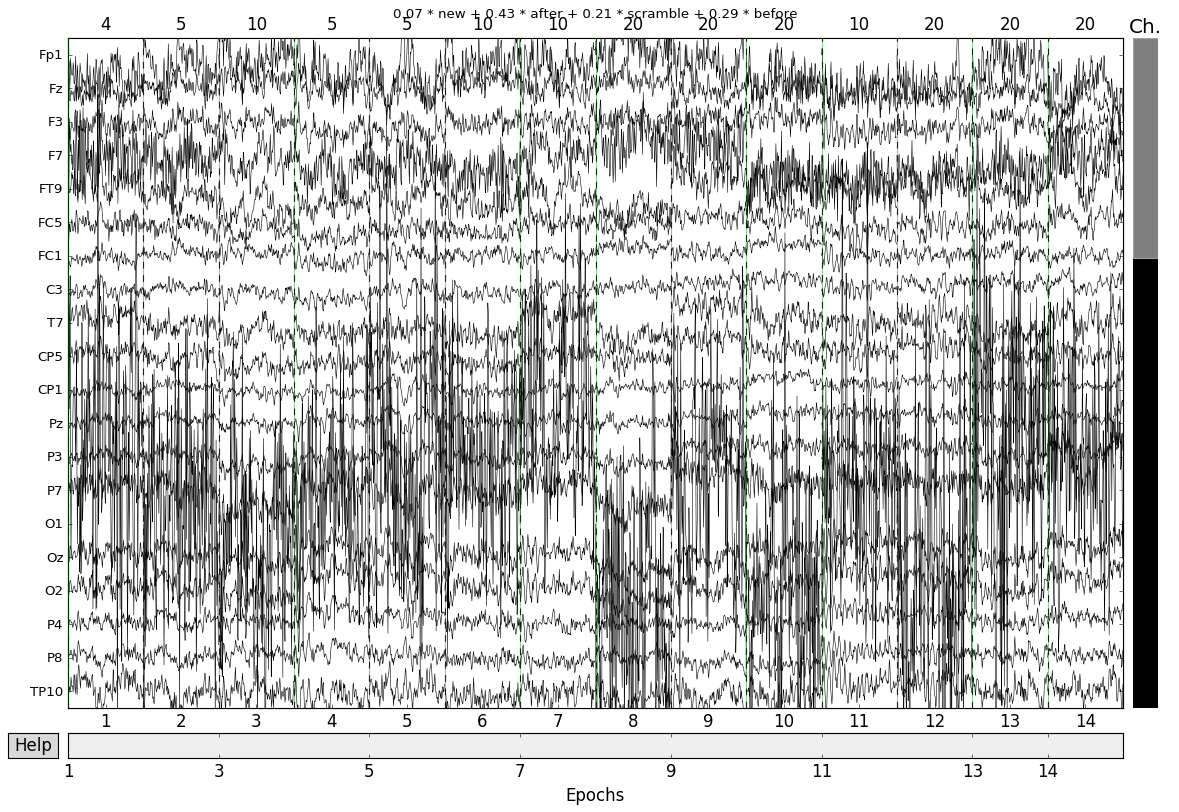

In [73]:
epochs.plot(n_epochs=200);

## Explore scores greater than 90

In [55]:
scores[:,-1] = [float(elem) for elem in scores[:,-1]]
scores[values_test >= .90]

C:\Users\Esimk_000\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  


array(['Ex10_Suj10_Run2-epo.fif', '0.809523809524'], 
      dtype='|S23')

In [61]:
values_test[values_test >= 0.90]

0.809523809524

In [71]:
score_ninety = [x for x in scores if float(x[1]) >= .90 and float(x[1]) <1.0]

## These three files have a score greater than .90, this is also relatively high.

In [72]:
score_ninety

[array(['Ex10_Suj25_Run4-epo.fif', '0.9'], 
       dtype='|S23'), array(['Ex10_Suj28_Run3-epo.fif', '0.914285714286'], 
       dtype='|S23'), array(['Ex10_Suj7_Run2-epo.fif', '0.909090909091'], 
       dtype='|S23')]

In [74]:
epochs = mne.read_epochs(op.join(drive_path, 'Ex10_Suj28_Run3-epo.fif'),
                          preload=True)

Reading E:\eeg_data\Ex10_Suj28_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
238 matching events found
Created an SSP operator (subspace dimension = 1)
238 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


## The first few channels look like they still have artifacts. 

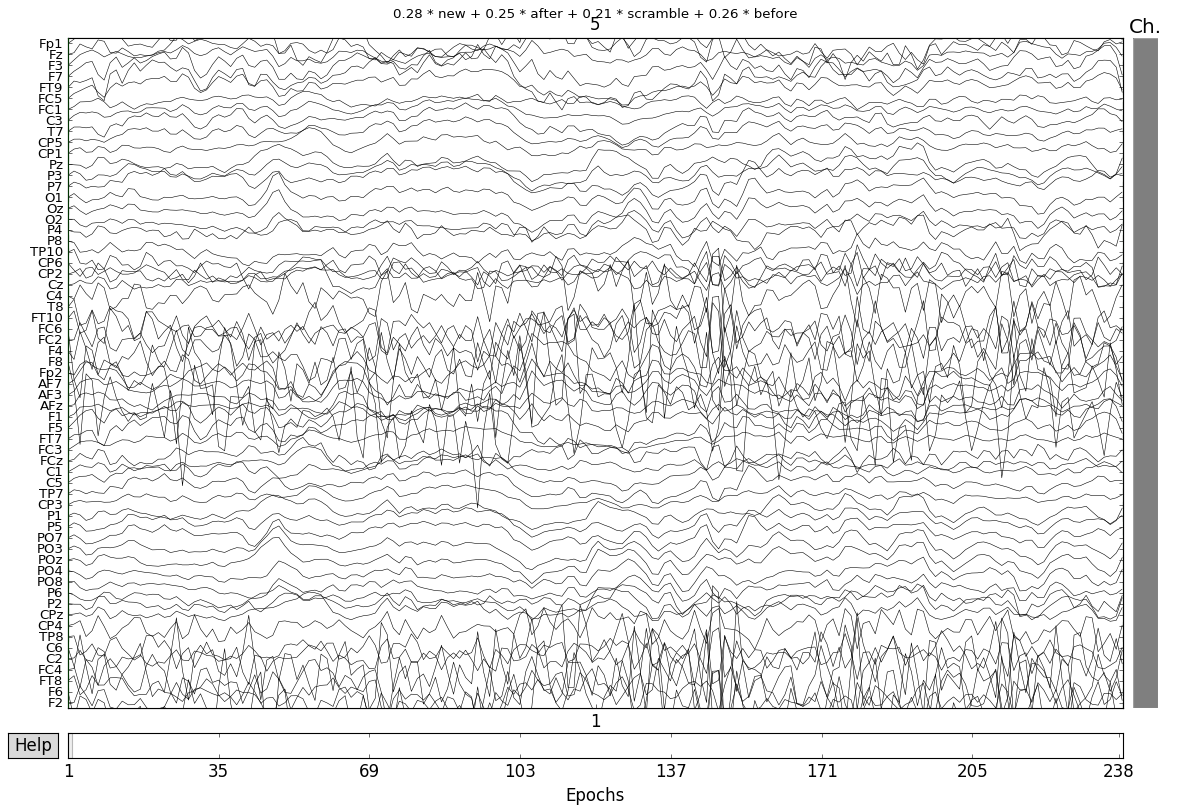

In [78]:
epochs.plot(n_channels = 61, n_epochs = 1);